In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.constraints import max_norm
import matplotlib.pyplot as plt

from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope

tf.random.set_seed(1234)

In [13]:
def data_tranpose(df):
    """
    Transposing and resetting the index to train.
    :param df:
    :type df:
    :return:
    :rtype:
    """
    df.drop(df.columns[0], axis=1, inplace=True)
    df.columns.values[0] = ""
    df.set_index(df.columns[0], inplace=True)

    df_output = df.transpose()
    df_output.reset_index(drop=True, inplace=True)
    df_output = df_output.astype("float32")

    return df_output

In [14]:
df_fitted = pd.read_csv("prison/prison_arima_fitted.csv")
df_actual = pd.read_csv("prison/prison_actual.csv")
df_forecasts = pd.read_csv("prison/prison_arima_forecasts.csv")

In [110]:
#df_ets_forecasts = pd.read_csv("prison/prison_ets_forecasts.csv")

In [111]:
#df_forecasts.iloc[0,2:] = df_ets_forecasts.iloc[0,2:]

In [15]:
df_feature_tranpose = data_tranpose(df_fitted)
df_actual_transpose = data_tranpose(df_actual)
df_forecasts_transpose = data_tranpose(df_forecasts)

In [16]:
df_feature_tranpose.shape

(40, 121)

In [17]:
df_feature_tranpose.head(5)

,Aggregated,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,ACT-Female,...,VIC-Male-Sentenced-ATSI,VIC-Male-Sentenced-Non-ATSI,WA-Female-Remanded-ATSI,WA-Female-Remanded-Non-ATSI,WA-Female-Sentenced-ATSI,WA-Female-Sentenced-Non-ATSI,WA-Male-Remanded-ATSI,WA-Male-Remanded-Non-ATSI,WA-Male-Sentenced-ATSI,WA-Male-Sentenced-Non-ATSI
0,24271.703125,177.826233,9008.982422,784.233826,5291.632324,1551.305908,524.473083,3531.959717,3406.643311,6.993000,...,125.879974,2560.481445,33.966,26.973,114.885002,94.907394,188.817474,305.702576,1055.942993,1585.412964
1,24456.992188,182.230774,9041.748047,805.233093,5351.988770,1513.173950,539.456116,3591.042480,3482.317383,7.387423,...,131.974365,2611.741699,34.000,27.000,114.901596,97.544830,194.014450,314.564117,1062.202515,1594.003784
2,24753.003906,187.230774,9105.125000,837.381958,5388.567383,1491.045410,528.465210,3677.300537,3618.820068,8.616979,...,132.974365,2675.820801,24.000,28.000,113.304741,105.524025,190.246231,340.564117,1148.104004,1666.329956
3,24461.708984,191.230774,8980.875000,810.611938,5380.762207,1519.998901,518.473267,3649.917969,3346.844727,7.474558,...,151.974365,2719.242920,28.000,21.000,92.300476,103.458305,183.936325,334.564117,1037.984863,1568.154053
4,24455.775391,208.230774,9022.333984,780.926392,5331.057129,1549.878418,498.102631,3563.627686,3453.395752,9.486750,...,152.974365,2660.540283,19.000,24.000,99.241249,96.415283,191.545792,315.564117,1053.550781,1633.910156


In [7]:
df_actual_transpose.shape

(40, 121)

In [116]:
df_actual_transpose.head(5)

,Aggregated,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,ACT-Female,...,VIC-Male-Sentenced-ATSI,VIC-Male-Sentenced-Non-ATSI,WA-Female-Remanded-ATSI,WA-Female-Remanded-Non-ATSI,WA-Female-Sentenced-ATSI,WA-Female-Sentenced-Non-ATSI,WA-Male-Remanded-ATSI,WA-Male-Remanded-Non-ATSI,WA-Male-Sentenced-ATSI,WA-Male-Sentenced-Non-ATSI
0,24296.0,178.0,9018.0,785.0,5294.0,1552.0,525.0,3534.0,3410.0,7.0,...,126.0,2563.0,34.0,27.0,115.0,95.0,189.0,306.0,1057.0,1587.0
1,24643.0,183.0,9099.0,822.0,5345.0,1511.0,540.0,3592.0,3551.0,10.0,...,127.0,2623.0,24.0,28.0,114.0,102.0,186.0,332.0,1125.0,1640.0
2,24511.0,187.0,9007.0,796.0,5368.0,1530.0,529.0,3678.0,3416.0,6.0,...,146.0,2682.0,28.0,21.0,99.0,102.0,178.0,326.0,1070.0,1592.0
3,24393.0,204.0,8991.0,760.0,5321.0,1556.0,519.0,3649.0,3393.0,12.0,...,147.0,2658.0,19.0,24.0,97.0,96.0,181.0,307.0,1049.0,1620.0
4,24524.0,190.0,9103.0,806.0,5423.0,1536.0,476.0,3556.0,3434.0,13.0,...,151.0,2582.0,29.0,24.0,96.0,98.0,214.0,316.0,1013.0,1644.0


In [8]:
df_forecasts_transpose.shape

(8, 121)

In [68]:
df_forecasts_transpose.head(5)

,Aggregated,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,ACT-Female,...,VIC-Male-Sentenced-ATSI,VIC-Male-Sentenced-Non-ATSI,WA-Female-Remanded-ATSI,WA-Female-Remanded-Non-ATSI,WA-Female-Sentenced-ATSI,WA-Female-Sentenced-Non-ATSI,WA-Male-Remanded-ATSI,WA-Male-Remanded-Non-ATSI,WA-Male-Sentenced-ATSI,WA-Male-Sentenced-Non-ATSI
0,35052.453125,347.230774,10734.232422,1587.358887,7382.901855,2737.328125,437.392548,6568.919434,5444.671387,16.769266,...,364.974365,4327.782715,86.0,61.0,188.937164,189.418045,446.092316,648.564087,1432.727295,2375.884521
1,35937.742188,351.461548,10921.754883,1597.791138,7543.861328,2811.419678,457.783661,6708.636230,5514.964844,16.769266,...,370.948730,4373.406738,86.0,61.0,188.937164,191.809113,462.648041,657.128235,1432.727295,2384.769287
2,36316.132812,355.692322,10704.757812,1603.221069,7616.755371,2878.766113,463.600006,6884.341309,5552.009766,16.769266,...,376.923065,4434.993652,86.0,61.0,188.937164,194.200195,448.909576,665.692322,1432.727295,2389.183350
3,36867.601562,359.923065,10714.093750,1635.202515,7736.522949,2968.016846,470.778931,7139.030762,5620.917969,16.769266,...,382.897430,4518.208496,86.0,61.0,188.937164,196.591278,453.771149,674.256409,1432.727295,2391.375977
4,37313.347656,364.153839,10803.640625,1653.468994,7893.648438,3038.884766,438.178345,7274.526855,5659.290039,16.769266,...,388.871796,4521.605957,86.0,61.0,188.937164,198.982346,474.194580,682.820496,1432.727295,2392.465332


In [117]:
# upper level fitted time series
df_level1_ts = df_feature_tranpose.columns[0]
df_level2_ts = df_feature_tranpose.columns[1:9]
df_level3_ts = df_feature_tranpose.columns[9:(10+16-1)]
df_level4_ts = df_feature_tranpose.columns[25:(26+32-1)]
df_level5_ts = df_feature_tranpose.columns[57:(58+64-1)]

In [70]:
len(df_level5_ts)

64

In [118]:
matching_level1_indexes = {}

In [119]:
matching_level1_indexes[0] = np.arange(57,121).tolist()

In [120]:
matching_level1_indexes

{0: [57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120]}

In [121]:
matching_level2_indexes = {}

In [122]:
matching_level2_bottom_split = [i.split('-', 1)[0] for i in df_level5_ts]

In [123]:
for var in range(1,9):
    match_name = df_feature_tranpose.columns[var]
    indices = [i for i, s in enumerate(matching_level2_bottom_split) if match_name in s]
    matching_level2_indexes[var] = [x+57 for x in indices]

In [124]:
matching_level2_indexes

{1: [57, 58, 59, 60, 61, 62, 63, 64],
 2: [65, 66, 67, 68, 69, 70, 71, 72],
 3: [73, 74, 75, 76, 77, 78, 79, 80],
 4: [81, 82, 83, 84, 85, 86, 87, 88],
 5: [89, 90, 91, 92, 93, 94, 95, 96],
 6: [97, 98, 99, 100, 101, 102, 103, 104],
 7: [105, 106, 107, 108, 109, 110, 111, 112],
 8: [113, 114, 115, 116, 117, 118, 119, 120]}

In [125]:
matching_level3_indexes = {}

In [126]:
matching_level3_bottom_split = ["-".join(i.split("-", 2)[:2]) for i in df_level5_ts]

In [127]:
for var in range(9,25):
    match_name = df_feature_tranpose.columns[var]
    indices = [i for i, s in enumerate(matching_level3_bottom_split) if match_name in s]
    matching_level3_indexes[var] = [x+57 for x in indices]

In [128]:
matching_level3_indexes

{9: [57, 58, 59, 60],
 10: [61, 62, 63, 64],
 11: [65, 66, 67, 68],
 12: [69, 70, 71, 72],
 13: [73, 74, 75, 76],
 14: [77, 78, 79, 80],
 15: [81, 82, 83, 84],
 16: [85, 86, 87, 88],
 17: [89, 90, 91, 92],
 18: [93, 94, 95, 96],
 19: [97, 98, 99, 100],
 20: [101, 102, 103, 104],
 21: [105, 106, 107, 108],
 22: [109, 110, 111, 112],
 23: [113, 114, 115, 116],
 24: [117, 118, 119, 120]}

In [129]:
matching_level4_indexes = {}

In [130]:
matching_level4_bottom_split = ["-".join(i.split("-", 3)[:3]) for i in df_level5_ts]

In [131]:
for var in range(25,57):
    match_name = df_feature_tranpose.columns[var]
    indices = [i for i, s in enumerate(matching_level4_bottom_split) if match_name in s]
    matching_level4_indexes[var] = [x+57 for x in indices]

In [132]:
matching_level4_indexes

{25: [57, 58],
 26: [59, 60],
 27: [61, 62],
 28: [63, 64],
 29: [65, 66],
 30: [67, 68],
 31: [69, 70],
 32: [71, 72],
 33: [73, 74],
 34: [75, 76],
 35: [77, 78],
 36: [79, 80],
 37: [81, 82],
 38: [83, 84],
 39: [85, 86],
 40: [87, 88],
 41: [89, 90],
 42: [91, 92],
 43: [93, 94],
 44: [95, 96],
 45: [97, 98],
 46: [99, 100],
 47: [101, 102],
 48: [103, 104],
 49: [105, 106],
 50: [107, 108],
 51: [109, 110],
 52: [111, 112],
 53: [113, 114],
 54: [115, 116],
 55: [117, 118],
 56: [119, 120]}

In [11]:
df_feature_tranpose.head(5)

,Aggregated,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,ACT-Female,...,VIC-Male-Sentenced-ATSI,VIC-Male-Sentenced-Non-ATSI,WA-Female-Remanded-ATSI,WA-Female-Remanded-Non-ATSI,WA-Female-Sentenced-ATSI,WA-Female-Sentenced-Non-ATSI,WA-Male-Remanded-ATSI,WA-Male-Remanded-Non-ATSI,WA-Male-Sentenced-ATSI,WA-Male-Sentenced-Non-ATSI
0,24271.703125,177.826233,9008.982422,784.233826,5291.632324,1551.305908,524.473083,3531.959717,3406.643311,6.993000,...,125.879974,2560.481445,33.966,26.973,114.885002,94.907394,188.817474,305.702576,1055.942993,1585.412964
1,24456.992188,182.230774,9041.748047,805.233093,5351.988770,1513.173950,539.456116,3591.042480,3482.317383,7.387423,...,131.974365,2611.741699,34.000,27.000,114.901596,97.544830,194.014450,314.564117,1062.202515,1594.003784
2,24753.003906,187.230774,9105.125000,837.381958,5388.567383,1491.045410,528.465210,3677.300537,3618.820068,8.616979,...,132.974365,2675.820801,24.000,28.000,113.304741,105.524025,190.246231,340.564117,1148.104004,1666.329956
3,24461.708984,191.230774,8980.875000,810.611938,5380.762207,1519.998901,518.473267,3649.917969,3346.844727,7.474558,...,151.974365,2719.242920,28.000,21.000,92.300476,103.458305,183.936325,334.564117,1037.984863,1568.154053
4,24455.775391,208.230774,9022.333984,780.926392,5331.057129,1549.878418,498.102631,3563.627686,3453.395752,9.486750,...,152.974365,2660.540283,19.000,24.000,99.241249,96.415283,191.545792,315.564117,1053.550781,1633.910156


In [10]:
df_actual_transpose.head(5)

,Aggregated,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,ACT-Female,...,VIC-Male-Sentenced-ATSI,VIC-Male-Sentenced-Non-ATSI,WA-Female-Remanded-ATSI,WA-Female-Remanded-Non-ATSI,WA-Female-Sentenced-ATSI,WA-Female-Sentenced-Non-ATSI,WA-Male-Remanded-ATSI,WA-Male-Remanded-Non-ATSI,WA-Male-Sentenced-ATSI,WA-Male-Sentenced-Non-ATSI
0,24296.0,178.0,9018.0,785.0,5294.0,1552.0,525.0,3534.0,3410.0,7.0,...,126.0,2563.0,34.0,27.0,115.0,95.0,189.0,306.0,1057.0,1587.0
1,24643.0,183.0,9099.0,822.0,5345.0,1511.0,540.0,3592.0,3551.0,10.0,...,127.0,2623.0,24.0,28.0,114.0,102.0,186.0,332.0,1125.0,1640.0
2,24511.0,187.0,9007.0,796.0,5368.0,1530.0,529.0,3678.0,3416.0,6.0,...,146.0,2682.0,28.0,21.0,99.0,102.0,178.0,326.0,1070.0,1592.0
3,24393.0,204.0,8991.0,760.0,5321.0,1556.0,519.0,3649.0,3393.0,12.0,...,147.0,2658.0,19.0,24.0,97.0,96.0,181.0,307.0,1049.0,1620.0
4,24524.0,190.0,9103.0,806.0,5423.0,1536.0,476.0,3556.0,3434.0,13.0,...,151.0,2582.0,29.0,24.0,96.0,98.0,214.0,316.0,1013.0,1644.0


In [133]:
df_final_labels = df_actual_transpose.copy()

In [134]:
X_train, X_valid, Y_train, Y_valid = train_test_split(df_feature_tranpose, df_final_labels, test_size=0.2, random_state=42)

In [135]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train))  # training set
X_valid = pd.DataFrame(scaler.transform(X_valid))  # validation set
df_feature_scaled_test = pd.DataFrame(scaler.transform(df_feature_tranpose))  # training set during testing
df_forecasts_scaled = pd.DataFrame(scaler.transform(df_forecasts_transpose))  # testing set

In [89]:
label_size = df_final_labels.iloc[:,57:].shape[1]

In [90]:
label_size

64

In [136]:
all_indexes = {**matching_level1_indexes, **matching_level2_indexes, **matching_level3_indexes, **matching_level4_indexes}

In [137]:
all_indexes

{0: [57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120],
 1: [57, 58, 59, 60, 61, 62, 63, 64],
 2: [65, 66, 67, 68, 69, 70, 71, 72],
 3: [73, 74, 75, 76, 77, 78, 79, 80],
 4: [81, 82, 83, 84, 85, 86, 87, 88],
 5: [89, 90, 91, 92, 93, 94, 95, 96],
 6: [97, 98, 99, 100, 101, 102, 103, 104],
 7: [105, 106, 107, 108, 109, 110, 111, 112],
 8: [113, 114, 115, 116, 117, 118, 119, 120],
 9: [57, 58, 59, 60],
 10: [61, 62, 63, 64],
 11: [65, 66, 67, 68],
 12: [69, 70, 71, 72],
 13: [73, 74, 75, 76],
 14: [77, 78, 79, 80],
 15: [81, 82, 83, 84],
 16: [85, 86, 87, 88],
 17: [89, 90, 91, 92],
 18: [93, 94, 95, 96],
 19: [97, 98, 99, 100],
 20: [101, 10

In [138]:
###### Model building
def custom_loss_fn(reconciliation_loss_lambda):
    def loss(data, y_pred):
        """
        Computes the custom loss for model training, given the actuals and predictions
        :param data:
        :type data:
        :param y_pred:
        :type y_pred:
        :return:
        :rtype:
        """
        rec_loss_list = list()
        all_predictions = y_pred[:, :64]
        actual = data[:, 57:]
        # prediction error
        loss_fn = tf.losses.MeanSquaredError()
        prediction_error = loss_fn(actual, all_predictions)
        
        # Reconcilation error
        for key in all_indexes:
            higher_hie_index = key
            lower_hie_index = all_indexes[higher_hie_index]

            higher_hie_ts = tf.reshape(data[:, higher_hie_index], [-1, 1])
            higher_hie_ts_actual = higher_hie_ts
            
            lower_index = (lower_hie_index[0] - 57)
            high_index = (lower_hie_index[-1] - 57)

            lower_hie_ts = y_pred[:, lower_index: (high_index + 1)]
            lower_hie_ts_agg_pred = tf.reduce_sum(lower_hie_ts, axis=1, keepdims=True)
            recon_loss = tf.math.reduce_mean(tf.square(higher_hie_ts_actual - lower_hie_ts_agg_pred))
            rec_loss_list.append(recon_loss)

        recon_loss_agg = tf.reduce_sum(rec_loss_list)
        final_loss = prediction_error + reconciliation_loss_lambda* recon_loss_agg
        return final_loss
    return loss

In [140]:
def val_loss_fn(y_actual, y_pred):
    """
    Computes the error for the validation set
    :param y_actual:
    :type y_actual:
    :param y_pred:
    :type y_pred:
    :return:
    :rtype:
    """
    val_loss = np.mean(np.sqrt(tf.losses.MSE(y_actual.values[:, 57:], y_pred)))
    return val_loss

In [141]:
def build_and_compile_model(hyperparams):
    """
    Specify an FFNN model given a specific hyperparameter config
    :return:
    :rtype:
    """
    tf.keras.backend.clear_session()  # destroy previously built models
    tf.random.set_seed(1234)  # set seed for reproducibility

    no_layers = hyperparams['no_layers']
    no_units_layer = hyperparams['no_units_layer']
    learning_rate = hyperparams['learning_rate']
    dropout_rate = hyperparams['dropout_rate']
    max_norm_value = hyperparams['max_norm_value']
    reconciliation_loss_lambda = hyperparams['reconciliation_loss_lambda']

    inputs = keras.Input(shape=df_feature_tranpose.shape[1])
    last_output = inputs
    for layer in range(no_layers):
        layer_output = layers.Dense(no_units_layer[layer],
                                   kernel_constraint=max_norm(max_norm_value))(last_output)
        x = layers.BatchNormalization()(layer_output)
        x = keras.activations.relu(x)
        last_output = layers.Dropout(dropout_rate)(x)

    model_outputs = layers.Dense(label_size)(last_output)

    bottom_level_actual = (inputs[:, 57:] - tf.constant(scaler.min_[57:])) / tf.constant(scaler.scale_[57:])

    outputs = tf.add(model_outputs, bottom_level_actual)  # skip connection from input to bypass the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss=custom_loss_fn(reconciliation_loss_lambda=reconciliation_loss_lambda),
                  optimizer=tf.keras.optimizers.Adam(learning_rate))
    return model

In [142]:
def plot_loss(history):
    """
    Plot the loss curves of the model
    :param history:
    :type history:
    :return:
    :rtype:
    """
    plt.plot(history.history['loss'], label='loss')
    # plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([100, 200])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
    plt.show()

In [143]:
def validate_model(hyperparams):
    """
    Build and train FFNN model and return the validation loss for hyperparameter
    tuning
    :param hyperparameters_config:
    :type hyperparameters_config:
    :return:
    :rtype:
    """
    hyperparams['no_layers'] = hyperparams['layers']['no_layers']
    hyperparams['no_units_layer'] = hyperparams['layers']['no_units_layer']

    hierac_model = build_and_compile_model(hyperparams)


    history = hierac_model.fit(
        X_train, Y_train,
        batch_size=hyperparams['batch_size'],
        epochs=hyperparams['epochs'],
        verbose=1
    )

    validation_predictions = hierac_model.predict(x=X_valid)
    val_loss = val_loss_fn(Y_valid, validation_predictions)

    # hist = pd.DataFrame(history.history)

    return val_loss

In [144]:
def test_model(hyperparams):
    """
    Testing of the model with the best hyperparameter config found
    :param best_hyperparams:
    :type best_hyperparams:
    :return:
    :rtype:
    """
    hyperparams['no_layers'] = int(hyperparams['layers'] + 1)
    hyperparams['no_units_layer'] = [int(hyperparams['no_units_layer_' + str(hyperparams['layers'] + 1) + "_" + str(j)])
                for j in range(1, (hyperparams['layers'] + 2))]
    hierac_model = build_and_compile_model(hyperparams)

    history = hierac_model.fit(
        df_feature_scaled_test, df_final_labels,
        batch_size=int(hyperparams['batch_size']),
        epochs=int(hyperparams['epochs']),
        verbose=1
    )

    plot_loss(history)

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist.head()

    # forward propagate the forecasts to get the adjusted forecasts
    adjusted_forecasts = hierac_model.predict(x=df_forecasts_scaled)
    return adjusted_forecasts

In [ ]:
######## Tune hyperparameters
layers_upper = 5
layers_list = []
for i in range(1, (layers_upper + 1)):
    layer_dict = {
        'no_layers': i,
        'no_units_layer': [scope.int(hp.quniform('no_units_layer_' + str(i) + "_" + str(j), 1, 256, 1))
                          for j in range(1, (i+1))]
    }
    layers_list.append(layer_dict)

fspace = {
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.1),
    'layers': hp.choice('layers', layers_list),
    'batch_size': scope.int(hp.quniform('batch_size', 1, X_train.shape[0], 1)),
    'epochs': scope.int(hp.quniform('epochs', 10, 200, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
    'max_norm_value': hp.uniform('max_norm_value', 0, 10),
    'reconciliation_loss_lambda': hp.uniform('reconciliation_loss_lambda', 0.1, 0.9)
}

trials = Trials()
max_evals = 50
best = fmin(
    fn=validate_model,
    space=fspace,
    algo=tpe.suggest,
    trials=trials,
    max_evals=max_evals
)

Epoch 1/91                                            
1/2 [==============>...............]                  
 - ETA: 5s - loss: 86390.6328                         
                                                      
2/2 [==============================]                  
 - 5s 7ms/step - loss: 89933.6693                     

Epoch 2/91                                            
1/2 [==============>...............]                  
 - ETA: 0s - loss: 113226.8594                        
                                                     
2/2 [==============================]                  
 - 0s 6ms/step - loss: 112129.1823                    

Epoch 3/91                                            
1/2 [==============>...............]                  
 - ETA: 0s - loss: 111305.6328                        
                                                     
2/2 [==============================]                  
 - 0s 6ms/step - loss: 105445.9193                    

Epoch 4/9

 - ETA: 0s - loss: 39284.7188                         
                                                      
2/2 [==============================]                  
 - 0s 8ms/step - loss: 38427.1927                     

Epoch 51/91                                           
1/2 [==============>...............]                  
 - ETA: 0s - loss: 41701.6094                         
                                                      
2/2 [==============================]                  
 - 0s 8ms/step - loss: 39767.0990                     

Epoch 52/91                                           
1/2 [==============>...............]                  
 - ETA: 0s - loss: 37390.7070                         
                                                      
2/2 [==============================]                  
 - 0s 7ms/step - loss: 36168.3971                     

Epoch 53/91                                           
1/2 [==============>...............]                  
 - ETA:

 - ETA: 0s - loss: 123101.6172                                                 
                                                                              
3/3 [==============================]                                           
 - 0s 4ms/step - loss: 113587.3008                                             

Epoch 5/100                                                                    
1/3 [=========>....................]                                           
 - ETA: 0s - loss: 118708.1172                                                 
                                                                              
3/3 [==============================]                                           
 - 0s 3ms/step - loss: 117139.0703                                             

Epoch 6/100                                                                    
1/3 [=========>....................]                                           
 - ETA: 0s - loss: 90465.3906           

 - ETA: 0s - loss: 84353.9219                                                  
                                                                               
3/3 [==============================]                                           
 - 0s 4ms/step - loss: 77618.0332                                              

Epoch 39/100                                                                   
1/3 [=========>....................]                                           
 - ETA: 0s - loss: 40010.4023                                                  
                                                                               
3/3 [==============================]                                           
 - 0s 4ms/step - loss: 51542.2949                                              

Epoch 40/100                                                                   
1/3 [=========>....................]                                           
 - ETA: 0s - loss: 68093.3984         

 - ETA: 0s - loss: 51729.2969                                                  
                                                                               
3/3 [==============================]                                           
 - 0s 4ms/step - loss: 55535.2002                                              

Epoch 73/100                                                                   
1/3 [=========>....................]                                           
 - ETA: 0s - loss: 54597.5898                                                  
                                                                               
3/3 [==============================]                                           
 - 0s 4ms/step - loss: 51998.9424                                              

Epoch 74/100                                                                   
1/3 [=========>....................]                                           
 - ETA: 0s - loss: 37993.1289         

                                                                               
2/2 [==============================]                                            
 - 0s 8ms/step - loss: 111046.4115                                              

Epoch 5/132                                                                     
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 121996.3906                                                  
                                                                               
2/2 [==============================]                                            
 - 0s 9ms/step - loss: 115026.1510                                              

Epoch 6/132                                                                     
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 99050.3438                                                   
                            

Epoch 38/132                                                                    
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 80120.1953                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 8ms/step - loss: 79725.7526                                               

Epoch 39/132                                                                    
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 74694.0391                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 7ms/step - loss: 79719.3359                                               

Epoch 40/132              

 - ETA: 0s - loss: 60514.0703                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 6ms/step - loss: 68067.2734                                               

Epoch 71/132                                                                    
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 51300.3125                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 7ms/step - loss: 55882.4323                                               

Epoch 72/132                                                                    
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 67173.7

2/2 [==============================]                                            
 - 0s 7ms/step - loss: 56353.3320                                               

Epoch 104/132                                                                   
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 48383.7734                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 7ms/step - loss: 54081.1328                                               

Epoch 105/132                                                                   
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 62216.3438                                                   
                                                                                
2/2 [=====================

 - ETA: 0s - loss: 145651.4688                                                  
                                                                               
2/2 [==============================]                                            
 - 0s 4ms/step - loss: 146934.2812                                              

Epoch 4/164                                                                     
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 131320.5781                                                  
                                                                               
2/2 [==============================]                                            
 - 0s 4ms/step - loss: 141210.7552                                              

Epoch 5/164                                                                     
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 157559.87

 - ETA: 0s - loss: 73692.6445                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 61ms/step - loss: 75064.3099                                              

Epoch 37/164                                                                    
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 72826.7109                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 4ms/step - loss: 75282.0911                                               

Epoch 38/164                                                                    
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 97640.1

1/2 [==============>...............]                                            
 - ETA: 0s - loss: 60195.0977                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 22ms/step - loss: 63320.2070                                              

Epoch 69/164                                                                    
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 55809.7812                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 5ms/step - loss: 56788.9505                                               

Epoch 70/164                                                                    
1/2 [==============>......

                                                                                
2/2 [==============================]                                            
 - 0s 4ms/step - loss: 58830.1862                                               

Epoch 102/164                                                                   
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 54444.3047                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 5ms/step - loss: 58144.5990                                               

Epoch 103/164                                                                   
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 51499.0391                                                   
                          

 - 0s 5ms/step - loss: 43619.2474                                               

Epoch 135/164                                                                   
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 46346.3203                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 5ms/step - loss: 48980.5755                                               

Epoch 136/164                                                                   
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 36984.1992                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 4ms/step - loss: 419

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/2 [==============>...............]                                            
 - ETA: 3s - loss: 32166.1855                                                   
                                                                                
2/2 [==============================]                                            
 - 3s 7ms/step - loss: 30745.0840                                               

Epoch 2/50                                                                      
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 27987.4160                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 5ms/step - loss: 26547.1178                                               

Epoch 3/50                                                                      
1/2 [==============>......

2/2 [==============================]                                            
 - 0s 4ms/step - loss: 9718.3428                                                

Epoch 35/50                                                                     
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 8111.9443                                                    
                                                                               
2/2 [==============================]                                            
 - 0s 5ms/step - loss: 8698.0342                                                

Epoch 36/50                                                                     
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 9215.3105                                                    
                                                                               
2/2 [=======================

Epoch 1/63                                                                      
1/2 [==============>...............]                                            
 - ETA: 3s - loss: 94822.0000                                                   
                                                                                
2/2 [==============================]                                            
 - 4s 6ms/step - loss: 96143.2344                                               

Epoch 2/63                                                                      
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 103543.0625                                                  
                                                                               
2/2 [==============================]                                            
 - 0s 5ms/step - loss: 95905.6094                                               

Epoch 3/63                 

 - ETA: 0s - loss: 72797.0547                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 5ms/step - loss: 65787.3255                                               

Epoch 35/63                                                                     
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 63538.6367                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 6ms/step - loss: 60315.1497                                               

Epoch 36/63                                                                     
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 67904.7

Epoch 3/123                                                                     
 1/11 [=>............................]                                          
 - ETA: 0s - loss: 184700.2031                                                  
                                                                               
11/11 [==============================]                                          
 - 0s 1ms/step - loss: 126398.5703                                              

Epoch 4/123                                                                     
 1/11 [=>............................]                                          
 - ETA: 0s - loss: 172925.0938                                                  
                                                                               
11/11 [==============================]                                          
 - 0s 1ms/step - loss: 112352.0579                                              

Epoch 5/123                 

11/11 [==============================]                                          
 - 0s 2ms/step - loss: 94653.5081                                               

Epoch 37/123                                                                    
 1/11 [=>............................]                                          
 - ETA: 0s - loss: 54433.9180                                                   
                                                                                
11/11 [==============================]                                          
 - 0s 2ms/step - loss: 114875.0505                                              

Epoch 38/123                                                                    
 1/11 [=>............................]                                          
 - ETA: 0s - loss: 85791.3359                                                   
                                                                                
11/11 [===================

 1/11 [=>............................]                                          
 - ETA: 0s - loss: 133449.1562                                                  
                                                                               
11/11 [==============================]                                          
 - 0s 2ms/step - loss: 102158.6400                                              

Epoch 71/123                                                                    
 1/11 [=>............................]                                          
 - ETA: 0s - loss: 40178.8398                                                   
                                                                                
11/11 [==============================]                                          
 - 0s 2ms/step - loss: 73930.5954                                               

Epoch 72/123                                                                    
 1/11 [=>..................

 - 0s 2ms/step - loss: 113961.4196                                              

Epoch 104/123                                                                   
 1/11 [=>............................]                                          
 - ETA: 0s - loss: 53752.2617                                                   
                                                                                
11/11 [==============================]                                          
 - 0s 2ms/step - loss: 99370.3636                                               

Epoch 105/123                                                                   
 1/11 [=>............................]                                          
 - ETA: 0s - loss: 81789.2969                                                   
                                                                                
11/11 [==============================]                                          
 - 0s 2ms/step - loss: 103

2/2 [==============================]                                            
 - 0s 4ms/step - loss: 45125.8867                                               

Epoch 13/41                                                                     
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 37411.0898                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 4ms/step - loss: 34703.8893                                               

Epoch 14/41                                                                     
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 45892.7422                                                   
                                                                                
2/2 [=====================

 - ETA: 0s - loss: 100438.9609                                                  
                                                                               
16/16 [==============================]                                          
 - 0s 1ms/step - loss: 172755.8506                                              

Epoch 4/110                                                                     
 1/16 [>.............................]                                          
 - ETA: 0s - loss: 327510.3750                                                  
                                                                               
16/16 [==============================]                                          
 - 0s 1ms/step - loss: 170195.3603                                              

Epoch 5/110                                                                     
 1/16 [>.............................]                                          
 - ETA: 0s - loss: 174321.82

Epoch 37/110                                                                    
 1/16 [>.............................]                                          
 - ETA: 0s - loss: 98497.9766                                                   
                                                                                
16/16 [==============================]                                          
 - 0s 2ms/step - loss: 161585.1163                                              

Epoch 38/110                                                                    
 1/16 [>.............................]                                          
 - ETA: 0s - loss: 117211.3594                                                  
                                                                               
16/16 [==============================]                                          
 - 0s 2ms/step - loss: 175273.1535                                              

Epoch 39/110               

16/16 [==============================]                                          
 - 0s 2ms/step - loss: 167870.5717                                              

Epoch 71/110                                                                    
 1/16 [>.............................]                                          
 - ETA: 0s - loss: 60828.0430                                                   
                                                                                
16/16 [==============================]                                          
 - 0s 2ms/step - loss: 138325.4069                                              

Epoch 72/110                                                                    
 1/16 [>.............................]                                          
 - ETA: 0s - loss: 266373.8125                                                  
                                                                               
16/16 [====================

 - ETA: 0s - loss: 92236.4688                                                   
                                                                                
16/16 [==============================]                                          
 - 0s 2ms/step - loss: 139357.4196                                              

Epoch 105/110                                                                   
 1/16 [>.............................]                                          
 - ETA: 0s - loss: 79373.2578                                                   
                                                                                
16/16 [==============================]                                          
 - 0s 2ms/step - loss: 149764.2546                                              

Epoch 106/110                                                                   
 1/16 [>.............................]                                          
 - ETA: 0s - loss: 114252.

Epoch 26/125                                                                    
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 45639.9961                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 7ms/step - loss: 51335.8711                                               

Epoch 27/125                                                                    
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 52455.0586                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 6ms/step - loss: 51694.8216                                               

Epoch 28/125              

 - ETA: 0s - loss: 29079.5684                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 9ms/step - loss: 35947.5775                                               

Epoch 60/125                                                                    
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 39324.4766                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 9ms/step - loss: 42483.8516                                               

Epoch 61/125                                                                    
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 41261.1

2/2 [==============================]                                            
 - 0s 5ms/step - loss: 31063.1615                                               

Epoch 93/125                                                                    
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 28643.6816                                                   
                                                                                
2/2 [==============================]                                            
 - 0s 5ms/step - loss: 28166.6621                                               

Epoch 94/125                                                                    
1/2 [==============>...............]                                            
 - ETA: 0s - loss: 36414.3672                                                   
                                                                                
2/2 [=====================

 18%|█▊        | 9/50 [00:57<03:36,  5.29s/trial, best loss: 20.516210556030273]WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fbe6373d820> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Epoch 1/76                                                                       
1/2 [==============>...............]                                             
 - ETA: 3s - loss:

 - ETA: 0s - loss: 69881.7578                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 72568.4401                                                

Epoch 33/76                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 61758.4766                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 64563.5026                                                

Epoch 34/76                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - l

 - ETA: 0s - loss: 51225.4180                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 55605.6888                                                

Epoch 66/76                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 52020.5898                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 9ms/step - loss: 52089.7305                                                

Epoch 67/76                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - l

2/2 [==============================]                                             
 - 0s 5ms/step - loss: 29743.2617                                                

Epoch 21/196                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 32081.0156                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 28270.5391                                                

Epoch 22/196                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 28959.6699                                                    
                                                                                 
2/2 [=========

1/2 [==============>...............]                                             
 - ETA: 0s - loss: 21403.1582                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 4ms/step - loss: 22216.8939                                                

Epoch 54/196                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 23226.0254                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 4ms/step - loss: 21593.8053                                                

Epoch 55/196                                                                     
1/2 [=========

1/2 [==============>...............]                                             
 - ETA: 0s - loss: 15879.1104                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 16226.5785                                                

Epoch 87/196                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 22436.6211                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 22309.2695                                                

Epoch 88/196                                                                     
1/2 [=========

1/2 [==============>...............]                                             
 - ETA: 0s - loss: 17667.8203                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 48ms/step - loss: 17199.5456                                               

Epoch 120/196                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 18474.6797                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 18962.8685                                                

Epoch 121/196                                                                    
1/2 [=========

1/2 [==============>...............]                                             
 - ETA: 0s - loss: 18923.0098                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 19838.6491                                                

Epoch 152/196                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 11699.6045                                                    
                                                                                 
2/2 [==============================]                                             
 - ETA: 0s - loss: 13926.3579                                                    
                                                                                 
2/2 [==========

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 1/79                                                                       
1/2 [==============>...............]                                             
 - ETA: 3s - loss: 95744.8203                                                    
                                                                                 
2/2 [==============================]                                             
 - 3s 5ms/step - loss: 93551.5130                                                

Epoch 2/79                                                                       
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 106421.1484                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 4ms/step - loss: 98481.6120                                                

Epoch 3/79     

Epoch 32/79                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 40201.1641                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 9ms/step - loss: 58470.2578                                                

Epoch 33/79                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 51979.3008                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 9ms/step - loss: 51815.0560                                                

Epoch 34/79   

Epoch 65/79                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 39963.0078                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 43340.6016                                                

Epoch 66/79                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 63278.5430                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 57037.8529                                                

Epoch 67/79   

Epoch 1/66                                                                       
1/3 [=========>....................]                                             
 - ETA: 7s - loss: 145467.0312                                                   
                                                                                
3/3 [==============================]                                             
 - 4s 4ms/step - loss: 133527.6152                                               

Epoch 2/66                                                                       
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 130917.3828                                                   
                                                                                
3/3 [==============================]                                             
 - 0s 4ms/step - loss: 128162.4199                                               

Epoch 3/66      

Epoch 34/66                                                                      
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 104738.0078                                                   
                                                                                
3/3 [==============================]                                             
 - 0s 4ms/step - loss: 91093.2539                                                

Epoch 35/66                                                                      
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 67850.7969                                                    
                                                                                 
3/3 [==============================]                                             
 - 0s 4ms/step - loss: 75522.7578                                                

Epoch 36/66    

 26%|██▌       | 13/50 [01:19<03:17,  5.33s/trial, best loss: 20.516210556030273]WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fbe60c85b80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Epoch 1/80                                                                       
1/2 [==============>...............]                                             
 - ETA: 3s - loss

 - ETA: 0s - loss: 52691.8555                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 53318.3685                                                

Epoch 33/80                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 46591.2148                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 50275.2122                                                

Epoch 34/80                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - l

 - ETA: 0s - loss: 46137.0898                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 45672.1523                                                

Epoch 66/80                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 49901.2930                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 50988.5924                                                

Epoch 67/80                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - l

Epoch 1/66                                                                       
1/2 [==============>...............]                                             
 - ETA: 2s - loss: 169658.3125                                                   
                                                                                
2/2 [==============================]                                             
 - 3s 5ms/step - loss: 166868.9896                                               

Epoch 2/66                                                                       
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 164618.7188                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 163100.0312                                               

Epoch 3/66      

Epoch 34/66                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 119125.6328                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 4ms/step - loss: 109910.9401                                               

Epoch 35/66                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 117956.1484                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 4ms/step - loss: 117396.8203                                               

Epoch 36/66     

 30%|███       | 15/50 [01:28<03:08,  5.38s/trial, best loss: 20.516210556030273]WARNING:tensorflow:11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fbe64290790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Epoch 1/90                                                                       
1/2 [==============>...............]                                             
 - ETA: 3s - loss

 - ETA: 0s - loss: 36594.6250                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 37873.7292                                                

Epoch 33/90                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 35988.3320                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 34613.8190                                                

Epoch 34/90                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - l

 - 0s 6ms/step - loss: 39679.8984                                                

Epoch 65/90                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 35341.0156                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 36966.9479                                                

Epoch 66/90                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 49687.4102                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step

1/2 [==============>...............]                                             
 - ETA: 0s - loss: 178143.1719                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 4ms/step - loss: 181785.2969                                               

Epoch 7/179                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 166484.4219                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 167910.1406                                               

Epoch 8/179                                                                      
1/2 [===========

1/2 [==============>...............]                                             
 - ETA: 0s - loss: 149503.0000                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 7ms/step - loss: 151990.1250                                               

Epoch 40/179                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 126519.7578                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 7ms/step - loss: 132590.2005                                               

Epoch 41/179                                                                     
1/2 [===========

1/2 [==============>...............]                                             
 - ETA: 0s - loss: 129851.0391                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 142091.1589                                               

Epoch 73/179                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 124223.1172                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 7ms/step - loss: 125400.5495                                               

Epoch 74/179                                                                     
1/2 [===========

1/2 [==============>...............]                                             
 - ETA: 0s - loss: 137142.7656                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 131450.3906                                               

Epoch 106/179                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 154082.8281                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 44ms/step - loss: 150090.3906                                              

Epoch 107/179                                                                    
1/2 [===========

1/2 [==============>...............]                                             
 - ETA: 0s - loss: 125388.5469                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 7ms/step - loss: 125331.6823                                               

Epoch 139/179                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 131097.0781                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 7ms/step - loss: 126448.0625                                               

Epoch 140/179                                                                    
1/2 [===========

1/2 [==============>...............]                                             
 - ETA: 0s - loss: 125323.1328                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 127143.2786                                               

Epoch 172/179                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 111258.5859                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 119245.9401                                               

Epoch 173/179                                                                    
1/2 [===========

                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 90346.9818                                                

Epoch 24/187                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 98751.6562                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 95593.4271                                                

Epoch 25/187                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 87129.4844                                                    
              

Epoch 55/187                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 79428.7891                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 93773.5547                                                

Epoch 56/187                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 67037.7734                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 73363.4349                                                

Epoch 57/187  

Epoch 87/187                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 62702.3984                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 65923.2109                                                

Epoch 88/187                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 69852.7891                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 71847.8984                                                

Epoch 89/187  

Epoch 120/187                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 51216.0195                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 58144.7617                                                

Epoch 121/187                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 53328.1172                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 7ms/step - loss: 55887.6693                                                

Epoch 122/187 

Epoch 153/187                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 59275.4570                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 60114.3659                                                

Epoch 154/187                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 52265.2031                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 54839.2812                                                

Epoch 155/187 

Epoch 186/187                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 58044.0703                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 57732.3411                                                

Epoch 187/187                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 47641.8672                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 52410.3203                                                

 36%|███▌     

16/16 [==============================]                                           
 - 0s 1ms/step - loss: 177679.1236                                               

Epoch 7/160                                                                      
 1/16 [>.............................]                                           
 - ETA: 0s - loss: 242743.2344                                                   
                                                                                
16/16 [==============================]                                           
 - 0s 1ms/step - loss: 199434.2601                                               

Epoch 8/160                                                                      
 1/16 [>.............................]                                           
 - ETA: 0s - loss: 224423.9375                                                   
                                                                                
16/16 [=========

16/16 [==============================]                                           
 - 0s 1ms/step - loss: 155605.8074                                               

Epoch 40/160                                                                     
 1/16 [>.............................]                                           
 - ETA: 0s - loss: 147870.6094                                                   
                                                                                
16/16 [==============================]                                           
 - 0s 1ms/step - loss: 166438.1034                                               

Epoch 41/160                                                                     
 1/16 [>.............................]                                           
 - ETA: 0s - loss: 124038.5469                                                   
                                                                                
16/16 [=========

16/16 [==============================]                                           
 - 0s 1ms/step - loss: 229509.9127                                               

Epoch 73/160                                                                     
 1/16 [>.............................]                                           
 - ETA: 0s - loss: 68130.7812                                                    
                                                                                 
16/16 [==============================]                                           
 - 0s 1ms/step - loss: 171338.5496                                               

Epoch 74/160                                                                     
 1/16 [>.............................]                                           
 - ETA: 0s - loss: 108791.2734                                                   
                                                                                
16/16 [========

16/16 [==============================]                                           
 - 0s 1ms/step - loss: 188768.8497                                               

Epoch 106/160                                                                    
 1/16 [>.............................]                                           
 - ETA: 0s - loss: 90059.1172                                                    
                                                                                 
16/16 [==============================]                                           
 - 0s 1ms/step - loss: 158921.5239                                               

Epoch 107/160                                                                    
 1/16 [>.............................]                                           
 - ETA: 0s - loss: 358032.0000                                                   
                                                                                
16/16 [========

16/16 [==============================]                                           
 - 0s 1ms/step - loss: 204560.7500                                               

Epoch 139/160                                                                    
 1/16 [>.............................]                                           
 - ETA: 0s - loss: 260999.2969                                                   
                                                                                
16/16 [==============================]                                           
 - 0s 1ms/step - loss: 203340.5028                                               

Epoch 140/160                                                                    
 1/16 [>.............................]                                           
 - ETA: 0s - loss: 137146.3750                                                   
                                                                                
16/16 [=========

Epoch 10/154                                                                     
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 102898.9688                                                   
                                                                                
3/3 [==============================]                                             
 - 0s 3ms/step - loss: 83842.4590                                                

Epoch 11/154                                                                     
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 48079.4102                                                    
                                                                                 
3/3 [==============================]                                             
 - 0s 3ms/step - loss: 67060.2334                                                

Epoch 12/154   

                                                                                 
3/3 [==============================]                                             
 - 0s 3ms/step - loss: 62095.6357                                                

Epoch 42/154                                                                     
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 85207.8281                                                    
                                                                                 
3/3 [==============================]                                             
 - 0s 3ms/step - loss: 73818.2559                                                

Epoch 43/154                                                                     
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 52972.3594                                                    
              

Epoch 74/154                                                                     
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 48623.9883                                                    
                                                                                 
3/3 [==============================]                                             
 - 0s 3ms/step - loss: 56690.4180                                                

Epoch 75/154                                                                     
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 55721.9609                                                    
                                                                                 
3/3 [==============================]                                             
 - 0s 3ms/step - loss: 54143.2207                                                

Epoch 76/154  

Epoch 107/154                                                                    
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 52740.8906                                                    
                                                                                 
3/3 [==============================]                                             
 - 0s 3ms/step - loss: 47851.6836                                                

Epoch 108/154                                                                    
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 53787.9609                                                    
                                                                                 
3/3 [==============================]                                             
 - 0s 3ms/step - loss: 55207.8193                                                

Epoch 109/154 

Epoch 140/154                                                                    
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 35949.9453                                                    
                                                                                 
3/3 [==============================]                                             
 - 0s 6ms/step - loss: 39848.7324                                                

Epoch 141/154                                                                    
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 46394.7812                                                    
                                                                                 
3/3 [==============================]                                             
 - 0s 7ms/step - loss: 49004.5254                                                

Epoch 142/154 

Epoch 1/151                                                                      
1/7 [===>..........................]                                             
 - ETA: 19s - loss: 206840.6719                                                  
                                                                                 
7/7 [==============================]                                             
 - 3s 2ms/step - loss: 157265.2441                                               

Epoch 2/151                                                                      
1/7 [===>..........................]                                             
 - ETA: 0s - loss: 180791.1719                                                   
                                                                                
7/7 [==============================]                                             
 - 0s 2ms/step - loss: 147449.9570                                               

Epoch 3/151    

Epoch 34/151                                                                     
1/7 [===>..........................]                                             
 - ETA: 0s - loss: 97741.7031                                                    
                                                                                 
7/7 [==============================]                                             
 - 0s 2ms/step - loss: 92414.9434                                                

Epoch 35/151                                                                     
1/7 [===>..........................]                                             
 - ETA: 0s - loss: 79807.0312                                                    
                                                                                 
7/7 [==============================]                                             
 - 0s 2ms/step - loss: 83361.2822                                                

Epoch 36/151  

Epoch 67/151                                                                     
1/7 [===>..........................]                                             
 - ETA: 0s - loss: 78875.7891                                                    
                                                                                 
7/7 [==============================]                                             
 - 0s 2ms/step - loss: 86387.9121                                                

Epoch 68/151                                                                     
1/7 [===>..........................]                                             
 - ETA: 0s - loss: 69392.5469                                                    
                                                                                 
7/7 [==============================]                                             
 - 0s 2ms/step - loss: 72648.7261                                                

Epoch 69/151  

Epoch 100/151                                                                    
1/7 [===>..........................]                                             
 - ETA: 0s - loss: 105282.5625                                                   
                                                                                
7/7 [==============================]                                             
 - 0s 2ms/step - loss: 108926.8389                                               

Epoch 101/151                                                                    
1/7 [===>..........................]                                             
 - ETA: 0s - loss: 44281.4961                                                    
                                                                                 
7/7 [==============================]                                             
 - 0s 2ms/step - loss: 70135.8843                                                

Epoch 102/151  

Epoch 133/151                                                                    
1/7 [===>..........................]                                             
 - ETA: 0s - loss: 114798.3516                                                   
                                                                                
7/7 [==============================]                                             
 - 0s 2ms/step - loss: 83527.8447                                                

Epoch 134/151                                                                    
1/7 [===>..........................]                                             
 - ETA: 0s - loss: 58894.4922                                                    
                                                                                 
7/7 [==============================]                                             
 - 0s 2ms/step - loss: 74809.2500                                                

Epoch 135/151  

 - ETA: 0s - loss: 107830.6641                                                   
                                                                                
6/6 [==============================]                                             
 - 0s 2ms/step - loss: 88871.5658                                                

Epoch 14/171                                                                     
1/6 [====>.........................]                                             
 - ETA: 0s - loss: 103085.9609                                                   
                                                                                
6/6 [==============================]                                             
 - 0s 2ms/step - loss: 93413.4788                                                

Epoch 15/171                                                                     
1/6 [====>.........................]                                             
 - ETA: 0s - los

 - ETA: 0s - loss: 81473.4766                                                    
                                                                                 
6/6 [==============================]                                             
 - 0s 2ms/step - loss: 75982.9431                                                

Epoch 47/171                                                                     
1/6 [====>.........................]                                             
 - ETA: 0s - loss: 139770.2656                                                   
                                                                                
6/6 [==============================]                                             
 - 0s 2ms/step - loss: 99819.1417                                                

Epoch 48/171                                                                     
1/6 [====>.........................]                                             
 - ETA: 0s - lo

 - ETA: 0s - loss: 74961.8984                                                    
                                                                                 
6/6 [==============================]                                             
 - 0s 2ms/step - loss: 75180.6775                                                

Epoch 80/171                                                                     
1/6 [====>.........................]                                             
 - ETA: 0s - loss: 77138.0547                                                    
                                                                                 
6/6 [==============================]                                             
 - 0s 2ms/step - loss: 84177.0000                                                

Epoch 81/171                                                                     
1/6 [====>.........................]                                             
 - ETA: 0s - l

 - ETA: 0s - loss: 116728.9141                                                   
                                                                                
6/6 [==============================]                                             
 - 0s 2ms/step - loss: 93031.5190                                                

Epoch 113/171                                                                    
1/6 [====>.........................]                                             
 - ETA: 0s - loss: 76757.7344                                                    
                                                                                 
6/6 [==============================]                                             
 - 0s 2ms/step - loss: 78116.7935                                                

Epoch 114/171                                                                    
1/6 [====>.........................]                                             
 - ETA: 0s - lo

 - ETA: 0s - loss: 50819.6133                                                    
                                                                                 
6/6 [==============================]                                             
 - 0s 2ms/step - loss: 71815.7026                                                

Epoch 146/171                                                                    
1/6 [====>.........................]                                             
 - ETA: 0s - loss: 60917.5820                                                    
                                                                                 
6/6 [==============================]                                             
 - 0s 2ms/step - loss: 76707.3923                                                

Epoch 147/171                                                                    
1/6 [====>.........................]                                             
 - ETA: 0s - l

5/5 [==============================]                                             
 - 0s 2ms/step - loss: 155662.0182                                               

Epoch 6/135                                                                      
1/5 [=====>........................]                                             
 - ETA: 0s - loss: 117248.4141                                                   
                                                                                
5/5 [==============================]                                             
 - 0s 2ms/step - loss: 125439.8411                                               

Epoch 7/135                                                                      
1/5 [=====>........................]                                             
 - ETA: 0s - loss: 163075.3438                                                   
                                                                                
5/5 [===========

5/5 [==============================]                                             
 - 0s 2ms/step - loss: 142809.9206                                               

Epoch 39/135                                                                     
1/5 [=====>........................]                                             
 - ETA: 0s - loss: 128871.6797                                                   
                                                                                
5/5 [==============================]                                             
 - 0s 2ms/step - loss: 124583.9831                                               

Epoch 40/135                                                                     
1/5 [=====>........................]                                             
 - ETA: 0s - loss: 145519.6094                                                   
                                                                                
5/5 [===========

5/5 [==============================]                                             
 - 0s 2ms/step - loss: 110243.8659                                               

Epoch 72/135                                                                     
1/5 [=====>........................]                                             
 - ETA: 0s - loss: 223496.7812                                                   
                                                                                
5/5 [==============================]                                             
 - 0s 2ms/step - loss: 149497.7760                                               

Epoch 73/135                                                                     
1/5 [=====>........................]                                             
 - ETA: 0s - loss: 123189.8359                                                   
                                                                                
5/5 [===========

5/5 [==============================]                                             
 - 0s 3ms/step - loss: 141180.9258                                               

Epoch 105/135                                                                    
1/5 [=====>........................]                                             
 - ETA: 0s - loss: 133515.0312                                                   
                                                                                
5/5 [==============================]                                             
 - 0s 3ms/step - loss: 133298.1159                                               

Epoch 106/135                                                                    
1/5 [=====>........................]                                             
 - ETA: 0s - loss: 87457.9609                                                    
                                                                                 
5/5 [==========

Epoch 1/118                                                                      
1/2 [==============>...............]                                             
 - ETA: 3s - loss: 196264.5938                                                   
                                                                                
2/2 [==============================]                                             
 - 3s 5ms/step - loss: 198428.1562                                               

Epoch 2/118                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 216938.0938                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 4ms/step - loss: 204461.0104                                               

Epoch 3/118     

                                                                                
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 164319.3229                                               

Epoch 34/118                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 179431.1406                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 27ms/step - loss: 165819.3802                                              

Epoch 35/118                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 169887.0000                                                   
                

                                                                                
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 117421.6146                                               

Epoch 67/118                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 123842.5781                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 124157.5677                                               

Epoch 68/118                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 111244.0938                                                   
                

                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 92337.0677                                                

Epoch 100/118                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 96115.0078                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 95550.8047                                                

Epoch 101/118                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 102632.1484                                                   
              

 - 0s 4ms/step - loss: 120554.2865                                               

Epoch 13/146                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 116750.6406                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 4ms/step - loss: 117918.9792                                               

Epoch 14/146                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 113769.8047                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 4ms/step -

 - 0s 4ms/step - loss: 110785.3542                                               

Epoch 46/146                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 105756.7031                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 4ms/step - loss: 100190.6198                                               

Epoch 47/146                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 103618.8984                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 4ms/step -

 - 0s 5ms/step - loss: 98399.2057                                                

Epoch 79/146                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 88031.4688                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 109960.6562                                               

Epoch 80/146                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 112068.0000                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 5ms/step 

 - ETA: 0s - loss: 84899.8984                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 84708.9349                                                

Epoch 112/146                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 99128.4297                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 102008.5599                                               

Epoch 113/146                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - l

 - ETA: 0s - loss: 85673.0938                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 94143.9583                                                

Epoch 145/146                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 81095.9844                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 92104.5469                                                

Epoch 146/146                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - l

3/3 [==============================]                                             
 - 0s 6ms/step - loss: 63246.4941                                                

Epoch 30/168                                                                     
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 73120.4609                                                    
                                                                                 
3/3 [==============================]                                             
 - 0s 4ms/step - loss: 72988.9766                                                

Epoch 31/168                                                                     
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 57318.8008                                                    
                                                                                 
3/3 [=========

3/3 [==============================]                                             
 - 0s 3ms/step - loss: 62494.6104                                                

Epoch 63/168                                                                     
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 85217.6875                                                    
                                                                                 
3/3 [==============================]                                             
 - 0s 3ms/step - loss: 76306.4141                                                

Epoch 64/168                                                                     
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 61739.5508                                                    
                                                                                 
3/3 [=========

3/3 [==============================]                                             
 - 0s 4ms/step - loss: 67963.8281                                                

Epoch 96/168                                                                     
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 50982.0820                                                    
                                                                                 
3/3 [==============================]                                             
 - 0s 4ms/step - loss: 56280.9414                                                

Epoch 97/168                                                                     
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 65367.6992                                                    
                                                                                 
3/3 [=========

3/3 [==============================]                                             
 - 0s 6ms/step - loss: 50811.4932                                                

Epoch 129/168                                                                    
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 57032.8086                                                    
                                                                                 
3/3 [==============================]                                             
 - 0s 8ms/step - loss: 52153.2490                                                

Epoch 130/168                                                                    
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 36392.7891                                                    
                                                                                 
3/3 [=========

3/3 [==============================]                                             
 - 0s 4ms/step - loss: 52463.2285                                                

Epoch 162/168                                                                    
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 42528.6367                                                    
                                                                                 
3/3 [==============================]                                             
 - 0s 4ms/step - loss: 45238.7363                                                

Epoch 163/168                                                                    
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 50381.3594                                                    
                                                                                 
3/3 [=========

Epoch 25/141                                                                     
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 29694.0742                                                    
                                                                                 
3/3 [==============================]                                             
 - 0s 3ms/step - loss: 34861.4053                                                

Epoch 26/141                                                                     
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 32427.7383                                                    
                                                                                 
3/3 [==============================]                                             
 - 0s 3ms/step - loss: 36363.5820                                                

Epoch 27/141  

                                                                                 
3/3 [==============================]                                             
 - 0s 3ms/step - loss: 31382.7314                                                

Epoch 58/141                                                                     
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 27171.9375                                                    
                                                                                 
3/3 [==============================]                                             
 - 0s 4ms/step - loss: 27528.3828                                                

Epoch 59/141                                                                     
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 30397.7012                                                    
              

                                                                                 
3/3 [==============================]                                             
 - 0s 4ms/step - loss: 35341.8364                                                

Epoch 91/141                                                                     
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 25460.5117                                                    
                                                                                 
3/3 [==============================]                                             
 - 0s 4ms/step - loss: 28138.0542                                                

Epoch 92/141                                                                     
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 32390.8594                                                    
              

                                                                                 
3/3 [==============================]                                             
 - 0s 4ms/step - loss: 30173.6523                                                

Epoch 124/141                                                                    
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 26921.2344                                                    
                                                                                 
3/3 [==============================]                                             
 - 0s 4ms/step - loss: 29939.1611                                                

Epoch 125/141                                                                    
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 29984.5801                                                    
              

 - 0s 3ms/step - loss: 156098.1094                                               

Epoch 14/195                                                                     
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 140550.3750                                                   
                                                                                
4/4 [==============================]                                             
 - 0s 2ms/step - loss: 146695.4813                                               

Epoch 15/195                                                                     
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 169204.5000                                                   
                                                                                
4/4 [==============================]                                             
 - 0s 3ms/step -

 - 0s 3ms/step - loss: 131796.1891                                               

Epoch 47/195                                                                     
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 134859.1094                                                   
                                                                                
4/4 [==============================]                                             
 - 0s 3ms/step - loss: 151171.7906                                               

Epoch 48/195                                                                     
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 130346.4375                                                   
                                                                                
4/4 [==============================]                                             
 - 0s 3ms/step -

 - 0s 3ms/step - loss: 125002.5656                                               

Epoch 80/195                                                                     
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 86619.0234                                                    
                                                                                 
4/4 [==============================]                                             
 - 0s 3ms/step - loss: 95192.3641                                                

Epoch 81/195                                                                     
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 120203.6094                                                   
                                                                                
4/4 [==============================]                                             
 - 0s 3ms/step 

 - 0s 3ms/step - loss: 101264.2609                                               

Epoch 113/195                                                                    
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 64034.0312                                                    
                                                                                 
4/4 [==============================]                                             
 - 0s 3ms/step - loss: 97232.8734                                                

Epoch 114/195                                                                    
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 155236.8750                                                   
                                                                                
4/4 [==============================]                                             
 - 0s 3ms/step 

 - 0s 3ms/step - loss: 111919.8203                                               

Epoch 146/195                                                                    
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 160962.4062                                                   
                                                                                
4/4 [==============================]                                             
 - 0s 3ms/step - loss: 155829.1531                                               

Epoch 147/195                                                                    
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 146911.7500                                                   
                                                                                
4/4 [==============================]                                             
 - 0s 3ms/step -

 - 0s 3ms/step - loss: 119001.7156                                               

Epoch 179/195                                                                    
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 129873.3594                                                   
                                                                                
4/4 [==============================]                                             
 - 0s 11ms/step - loss: 117654.6203                                              

Epoch 180/195                                                                    
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 101683.0859                                                   
                                                                                
4/4 [==============================]                                             
 - 0s 3ms/step -

4/4 [==============================]                                             
 - 0s 3ms/step - loss: 133346.5078                                               

Epoch 15/101                                                                     
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 164994.9219                                                   
                                                                                
4/4 [==============================]                                             
 - 0s 3ms/step - loss: 143929.0250                                               

Epoch 16/101                                                                     
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 107578.0000                                                   
                                                                                
4/4 [===========

4/4 [==============================]                                             
 - 0s 4ms/step - loss: 141613.8328                                               

Epoch 48/101                                                                     
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 145023.6719                                                   
                                                                                
4/4 [==============================]                                             
 - 0s 6ms/step - loss: 133514.2875                                               

Epoch 49/101                                                                     
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 197170.5312                                                   
                                                                                
4/4 [===========

4/4 [==============================]                                             
 - 0s 3ms/step - loss: 131910.6875                                               

Epoch 81/101                                                                     
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 133736.3750                                                   
                                                                                
4/4 [==============================]                                             
 - 0s 3ms/step - loss: 117195.8719                                               

Epoch 82/101                                                                     
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 125414.2188                                                   
                                                                                
4/4 [===========

Epoch 11/118                                                                     
1/1 [==============================]                                             
 - ETA: 0s - loss: 36398.2188                                                    
                                                                                 
1/1 [==============================]                                             
 - 0s 5ms/step - loss: 36398.2188                                                

Epoch 12/118                                                                     
1/1 [==============================]                                             
 - ETA: 0s - loss: 36657.9336                                                    
                                                                                 
1/1 [==============================]                                             
 - 0s 5ms/step - loss: 36657.9336                                                

Epoch 13/118  

Epoch 44/118                                                                     
1/1 [==============================]                                             
 - ETA: 0s - loss: 21178.7734                                                    
                                                                                 
1/1 [==============================]                                             
 - 0s 5ms/step - loss: 21178.7734                                                

Epoch 45/118                                                                     
1/1 [==============================]                                             
 - ETA: 0s - loss: 20506.5449                                                    
                                                                                 
1/1 [==============================]                                             
 - 0s 5ms/step - loss: 20506.5449                                                

Epoch 46/118  

Epoch 77/118                                                                     
1/1 [==============================]                                             
 - ETA: 0s - loss: 14452.2686                                                    
                                                                                 
1/1 [==============================]                                             
 - 0s 5ms/step - loss: 14452.2686                                                

Epoch 78/118                                                                     
1/1 [==============================]                                             
 - ETA: 0s - loss: 12365.0117                                                    
                                                                                 
1/1 [==============================]                                             
 - 0s 5ms/step - loss: 12365.0117                                                

Epoch 79/118  

Epoch 110/118                                                                    
1/1 [==============================]                                             
 - ETA: 0s - loss: 11443.4014                                                    
                                                                                 
1/1 [==============================]                                             
 - 0s 6ms/step - loss: 11443.4014                                                

Epoch 111/118                                                                    
1/1 [==============================]                                             
 - ETA: 0s - loss: 10735.6162                                                    
                                                                                 
1/1 [==============================]                                             
 - 0s 6ms/step - loss: 10735.6162                                                

Epoch 112/118 

 - ETA: 0s - loss: 57861.3633                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 55658.2565                                                

Epoch 24/166                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 65599.6562                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 59047.0417                                                

Epoch 25/166                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - l

 - ETA: 0s - loss: 47168.5977                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 47624.9961                                                

Epoch 57/166                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 52775.2852                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 52860.9857                                                

Epoch 58/166                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - l

 - ETA: 0s - loss: 35370.4180                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 7ms/step - loss: 39315.6992                                                

Epoch 90/166                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 47554.0156                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 7ms/step - loss: 51085.2578                                                

Epoch 91/166                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - l

 - ETA: 0s - loss: 46994.4336                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 7ms/step - loss: 43055.4518                                                

Epoch 123/166                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 32684.7754                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 34374.3496                                                

Epoch 124/166                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - l

 - ETA: 0s - loss: 38232.5820                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 44368.0378                                                

Epoch 156/166                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 34216.5859                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 36431.4609                                                

Epoch 157/166                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - l

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/4 [======>.......................]                                             
 - ETA: 8s - loss: 177530.1250                                                   
                                                                                
4/4 [==============================]                                             
 - 3s 3ms/step - loss: 138867.1453                                               

Epoch 2/180                                                                      
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 97198.9062                                                    
                                                                                 
4/4 [==============================]                                             
 - 0s 3ms/step - loss: 129401.2875                                               

Epoch 3/180                                                                      
1/4 [======>...

1/4 [======>.......................]                                             
 - ETA: 0s - loss: 116057.8281                                                   
                                                                                
4/4 [==============================]                                             
 - 0s 4ms/step - loss: 103409.0844                                               

Epoch 35/180                                                                     
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 81099.0938                                                    
                                                                                 
4/4 [==============================]                                             
 - 0s 4ms/step - loss: 94965.7703                                                

Epoch 36/180                                                                     
1/4 [======>...

1/4 [======>.......................]                                             
 - ETA: 0s - loss: 114977.5156                                                   
                                                                                
4/4 [==============================]                                             
 - 0s 3ms/step - loss: 96790.6875                                                

Epoch 68/180                                                                     
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 113676.9141                                                   
                                                                                
4/4 [==============================]                                             
 - 0s 3ms/step - loss: 97924.6953                                                

Epoch 69/180                                                                     
1/4 [======>....

1/4 [======>.......................]                                             
 - ETA: 0s - loss: 93647.2969                                                    
                                                                                 
4/4 [==============================]                                             
 - 0s 4ms/step - loss: 88199.5797                                                

Epoch 101/180                                                                    
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 57935.0195                                                    
                                                                                 
4/4 [==============================]                                             
 - 0s 5ms/step - loss: 96450.6539                                                

Epoch 102/180                                                                    
1/4 [======>..

1/4 [======>.......................]                                             
 - ETA: 0s - loss: 95545.7656                                                    
                                                                                 
4/4 [==============================]                                             
 - 0s 3ms/step - loss: 90622.4703                                                

Epoch 134/180                                                                    
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 107819.3281                                                   
                                                                                
4/4 [==============================]                                             
 - 0s 3ms/step - loss: 96626.8672                                                

Epoch 135/180                                                                    
1/4 [======>...

1/4 [======>.......................]                                             
 - ETA: 0s - loss: 95141.3203                                                    
                                                                                 
4/4 [==============================]                                             
 - 0s 3ms/step - loss: 82049.8984                                                

Epoch 167/180                                                                    
1/4 [======>.......................]                                             
 - ETA: 0s - loss: 66370.9531                                                    
                                                                                 
4/4 [==============================]                                             
 - 0s 3ms/step - loss: 76889.6891                                                

Epoch 168/180                                                                    
1/4 [======>..

                                                                                 
11/11 [==============================]                                           
 - 0s 2ms/step - loss: 62466.8877                                                

Epoch 18/134                                                                     
 1/11 [=>............................]                                           
 - ETA: 0s - loss: 44203.0273                                                    
                                                                                 
11/11 [==============================]                                           
 - 0s 2ms/step - loss: 65613.4844                                                

Epoch 19/134                                                                     
 1/11 [=>............................]                                           
 - ETA: 0s - loss: 69094.6641                                                    
              

                                                                                
11/11 [==============================]                                           
 - 0s 2ms/step - loss: 70989.8512                                                

Epoch 51/134                                                                     
 1/11 [=>............................]                                           
 - ETA: 0s - loss: 50633.1758                                                    
                                                                                 
11/11 [==============================]                                           
 - 0s 2ms/step - loss: 48162.3896                                                

Epoch 52/134                                                                     
 1/11 [=>............................]                                           
 - ETA: 0s - loss: 93575.6797                                                    
               

                                                                                 
11/11 [==============================]                                           
 - 0s 2ms/step - loss: 57663.3781                                                

Epoch 84/134                                                                     
 1/11 [=>............................]                                           
 - ETA: 0s - loss: 40537.7617                                                    
                                                                                 
11/11 [==============================]                                           
 - 0s 2ms/step - loss: 47504.0501                                                

Epoch 85/134                                                                     
 1/11 [=>............................]                                           
 - ETA: 0s - loss: 25206.1777                                                    
              

                                                                                 
11/11 [==============================]                                           
 - 0s 2ms/step - loss: 54151.3382                                                

Epoch 117/134                                                                    
 1/11 [=>............................]                                           
 - ETA: 0s - loss: 50254.4180                                                    
                                                                                 
11/11 [==============================]                                           
 - 0s 2ms/step - loss: 54399.5850                                                

Epoch 118/134                                                                    
 1/11 [=>............................]                                           
 - ETA: 0s - loss: 44338.9688                                                    
              

 - 0s 5ms/step - loss: 64224.4479                                                

Epoch 14/104                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 63737.2617                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 62549.2956                                                

Epoch 15/104                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 63132.9570                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step

 - ETA: 0s - loss: 51407.6074                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 56ms/step - loss: 52098.5664                                               

Epoch 46/104                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 52798.1953                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 53332.2526                                                

Epoch 47/104                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - l

 - ETA: 0s - loss: 45125.6719                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 48790.2500                                                

Epoch 78/104                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 43982.9375                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 45620.0052                                                

Epoch 79/104                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - l

2/2 [==============================]                                             
 - 0s 5ms/step - loss: 118989.0859                                               

Epoch 5/123                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 112756.6484                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 104577.1068                                               

Epoch 6/123                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 87521.6094                                                    
                                                                                 
2/2 [==========

2/2 [==============================]                                             
 - 0s 5ms/step - loss: 42370.0612                                                

Epoch 38/123                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 50996.8789                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 54987.7461                                                

Epoch 39/123                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 43345.2969                                                    
                                                                                 
2/2 [=========

2/2 [==============================]                                             
 - 0s 5ms/step - loss: 42015.7148                                                

Epoch 71/123                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 36890.1367                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 36949.2487                                                

Epoch 72/123                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 37579.0000                                                    
                                                                                 
2/2 [=========

2/2 [==============================]                                             
 - 0s 5ms/step - loss: 24213.1810                                                

Epoch 104/123                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 21666.3379                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 23126.7012                                                

Epoch 105/123                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 25572.1895                                                    
                                                                                 
2/2 [=========

Epoch 12/112                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 95385.9531                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 94304.8490                                                

Epoch 13/112                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 90102.2656                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 4ms/step - loss: 99883.3646                                                

Epoch 14/112  

                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 54942.5924                                                

Epoch 45/112                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 49879.0742                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 60312.0690                                                

Epoch 46/112                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 58632.1758                                                    
              

                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 44661.0599                                                

Epoch 78/112                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 38708.8672                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 43551.0443                                                

Epoch 79/112                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 41010.3789                                                    
              

                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 34896.4674                                                

Epoch 111/112                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 34936.3828                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 39533.1354                                                

Epoch 112/112                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 35350.4648                                                    
              

 - 0s 4ms/step - loss: 100078.2656                                               

Epoch 30/49                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 101163.7031                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 4ms/step - loss: 99461.2552                                                

Epoch 31/49                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 100659.9375                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 4ms/step -

1/1 [==============================]                                             
 - ETA: 0s - loss: 70958.2812                                                    
                                                                                 
1/1 [==============================]                                             
 - 0s 6ms/step - loss: 70958.2812                                                

Epoch 13/96                                                                      
1/1 [==============================]                                             
 - ETA: 0s - loss: 66386.7969                                                    
                                                                                 
1/1 [==============================]                                             
 - 0s 6ms/step - loss: 66386.7969                                                

Epoch 14/96                                                                      
1/1 [=========

1/1 [==============================]                                             
 - ETA: 0s - loss: 43505.9492                                                    
                                                                                 
1/1 [==============================]                                             
 - 0s 7ms/step - loss: 43505.9492                                                

Epoch 46/96                                                                      
1/1 [==============================]                                             
 - ETA: 0s - loss: 40003.7578                                                    
                                                                                 
1/1 [==============================]                                             
 - 0s 7ms/step - loss: 40003.7578                                                

Epoch 47/96                                                                      
1/1 [=========

1/1 [==============================]                                             
 - ETA: 0s - loss: 29541.8770                                                    
                                                                                 
1/1 [==============================]                                             
 - 0s 8ms/step - loss: 29541.8770                                                

Epoch 79/96                                                                      
1/1 [==============================]                                             
 - ETA: 0s - loss: 32640.6406                                                    
                                                                                 
1/1 [==============================]                                             
 - 0s 9ms/step - loss: 32640.6406                                                

Epoch 80/96                                                                      
1/1 [=========

                                                                                 
2/2 [==============================]                                             
 - 0s 4ms/step - loss: 79478.8672                                                

Epoch 14/27                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 89240.9141                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 4ms/step - loss: 86651.6276                                                

Epoch 15/27                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 66067.4453                                                    
              

Epoch 1/128                                                                      
1/2 [==============>...............]                                             
 - ETA: 3s - loss: 166076.9062                                                   
                                                                                
2/2 [==============================]                                             
 - 3s 5ms/step - loss: 161857.6354                                               

Epoch 2/128                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 153597.7500                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 147605.0938                                               

Epoch 3/128     

Epoch 33/128                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 48186.7773                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 47423.2956                                                

Epoch 34/128                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 45314.3320                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 46136.4805                                                

Epoch 35/128  

Epoch 66/128                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 34847.9805                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 33875.0299                                                

Epoch 67/128                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 30931.3438                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 39502.8073                                                

Epoch 68/128  

Epoch 99/128                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 19654.6094                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 22094.6732                                                

Epoch 100/128                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 22400.9355                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 23895.4134                                                

Epoch 101/128 

 - ETA: 0s - loss: 141017.2344                                                   
                                                                                
3/3 [==============================]                                             
 - 0s 4ms/step - loss: 144398.5430                                               

Epoch 3/11                                                                       
1/3 [=========>....................]                                             
 - ETA: 0s - loss: 132647.1719                                                   
                                                                                
3/3 [==============================]                                             
 - 0s 4ms/step - loss: 139112.8398                                               

Epoch 4/11                                                                       
1/3 [=========>....................]                                             
 - ETA: 0s - los

2/2 [==============================]                                             
 - 0s 5ms/step - loss: 40726.0234                                                

Epoch 23/89                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 42183.2422                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 4ms/step - loss: 46351.1380                                                

Epoch 24/89                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 52893.1133                                                    
                                                                                 
2/2 [=========

1/2 [==============>...............]                                             
 - ETA: 0s - loss: 50645.3047                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 52557.9557                                                

Epoch 56/89                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 29026.9160                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 31049.4902                                                

Epoch 57/89                                                                      
1/2 [=========

1/2 [==============>...............]                                             
 - ETA: 0s - loss: 18572.5938                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 19654.3698                                                

Epoch 89/89                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 17128.3066                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 18213.4408                                                

 86%|████████▌ | 43/50 [04:14<00:33,  4.81s/trial, best loss: 20.516210556030273]WARNING:tensorf

Epoch 30/200                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 69809.5156                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 69119.0521                                                

Epoch 31/200                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 61304.5977                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 60057.4544                                                

Epoch 32/200  

                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 65995.8008                                                

Epoch 63/200                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 53017.0977                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 52250.0378                                                

Epoch 64/200                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 50981.9141                                                    
              

                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 53505.8385                                                

Epoch 96/200                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 47705.8320                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 45877.7122                                                

Epoch 97/200                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 50328.1797                                                    
              

                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 47816.5026                                                

Epoch 129/200                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 38750.9141                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 43175.9245                                                

Epoch 130/200                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 50484.1719                                                    
              

                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 45131.2799                                                

Epoch 162/200                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 41513.3477                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 44455.4180                                                

Epoch 163/200                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 44747.8555                                                    
              

                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 51240.5456                                                

Epoch 195/200                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 37889.9805                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 38312.9492                                                

Epoch 196/200                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 38280.7461                                                    
              

 - 0s 5ms/step - loss: 100557.2708                                               

Epoch 26/142                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 77503.3672                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 79816.2891                                                

Epoch 27/142                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 85111.2891                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step

 - 0s 5ms/step - loss: 67212.5990                                                

Epoch 59/142                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 53884.2422                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 61862.3516                                                

Epoch 60/142                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 70105.0000                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step

 - 0s 6ms/step - loss: 65596.2591                                                

Epoch 92/142                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 52502.7070                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 7ms/step - loss: 54364.8867                                                

Epoch 93/142                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 50576.7344                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 6ms/step

 - 0s 6ms/step - loss: 44297.0690                                                

Epoch 125/142                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 63197.1172                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 7ms/step - loss: 67237.8620                                                

Epoch 126/142                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 60971.3945                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 7ms/step

1/2 [==============>...............]                                             
 - ETA: 0s - loss: 116444.1562                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 4ms/step - loss: 116664.1354                                               

Epoch 15/187                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 123387.5000                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 4ms/step - loss: 117394.7812                                               

Epoch 16/187                                                                     
1/2 [===========

1/2 [==============>...............]                                             
 - ETA: 0s - loss: 85779.6250                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 4ms/step - loss: 88599.3229                                                

Epoch 47/187                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 73634.9219                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 4ms/step - loss: 73603.3229                                                

Epoch 48/187                                                                     
1/2 [=========

2/2 [==============================]                                             
 - 0s 5ms/step - loss: 66134.9049                                                

Epoch 79/187                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 71211.4688                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 4ms/step - loss: 70755.9635                                                

Epoch 80/187                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 48812.3633                                                    
                                                                                 
2/2 [=========

2/2 [==============================]                                             
 - 0s 5ms/step - loss: 59930.9805                                                

Epoch 112/187                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 70058.1562                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 74072.7500                                                

Epoch 113/187                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 53220.5273                                                    
                                                                                 
2/2 [=========

2/2 [==============================]                                             
 - 0s 6ms/step - loss: 48513.1328                                                

Epoch 145/187                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 42856.5859                                                    
                                                                                 
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 47723.8750                                                

Epoch 146/187                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 52066.6914                                                    
                                                                                 
2/2 [=========

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 1/192                                                                      
1/2 [==============>...............]                                             
 - ETA: 3s - loss: 200828.5156                                                   
                                                                                
2/2 [==============================]                                             
 - 3s 5ms/step - loss: 199821.5781                                               

Epoch 2/192                                                                      
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 185226.7344                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 194398.5365                                               

Epoch 3/192     

Epoch 33/192                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 204167.1406                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 199758.6510                                               

Epoch 34/192                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 202473.4375                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 199081.7396                                               

Epoch 35/192    

Epoch 64/192                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 196262.5156                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 194773.0260                                               

Epoch 65/192                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 196790.0625                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 194376.6146                                               

Epoch 66/192    

Epoch 97/192                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 172632.3594                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 6ms/step - loss: 180355.9010                                               

Epoch 98/192                                                                     
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 185874.3125                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 184295.6562                                               

Epoch 99/192    

Epoch 130/192                                                                    
1/2 [==============>...............]                                             
 - ETA: 0s - loss: 190269.2656                                                   
                                                                                
2/2 [==============================]                                             
 - 0s 5ms/step - loss: 185756.9115                                               

Epoch 131/192                                                                    
                                                                                 

In [146]:
df_bottom_phie_ts = df_level5_ts

Epoch 1/187
2/2 [==============================] - 3s 3ms/step - loss: 183904.8490
Epoch 2/187
2/2 [==============================] - 0s 2ms/step - loss: 178835.8646
Epoch 3/187
2/2 [==============================] - 0s 3ms/step - loss: 183702.9948
Epoch 4/187
2/2 [==============================] - 0s 3ms/step - loss: 155507.4635
Epoch 5/187
2/2 [==============================] - 0s 2ms/step - loss: 164111.7865
Epoch 6/187
2/2 [==============================] - 0s 3ms/step - loss: 160910.9010
Epoch 7/187
2/2 [==============================] - 0s 2ms/step - loss: 153638.2448
Epoch 8/187
2/2 [==============================] - 0s 2ms/step - loss: 140447.5156
Epoch 9/187
2/2 [==============================] - 0s 2ms/step - loss: 140034.7969
Epoch 10/187
2/2 [==============================] - 0s 2ms/step - loss: 133279.7344
Epoch 11/187
2/2 [==============================] - 0s 2ms/step - loss: 130661.6927
Epoch 12/187
2/2 [==============================] - 0s 2ms/step - loss: 116642.7083
E

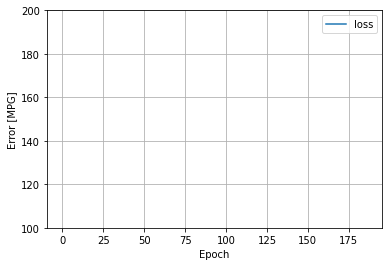

In [147]:
######### Test with the best hyperparameter combination
adjusted_forecasts = test_model(best)
adjusted_forecasts = pd.DataFrame(adjusted_forecasts)
adjusted_forecasts.columns = df_bottom_phie_ts
adjusted_forecasts = adjusted_forecasts.transpose()
output_file_name = "prison_arima/mse_ets2_forecasts_arima_prison_adjusted_fixed_forecasts_lambda_" + str(best['reconciliation_loss_lambda']) + ".csv"
adjusted_forecasts.to_csv(output_file_name)

best_config_df = pd.DataFrame(best)
best_config_file_name = "prison_arima/mse_ets2_forecasts_arima_best_config_fixed_lambda_" + str(best['reconciliation_loss_lambda']) + ".csv"
best_config_df.to_csv(best_config_file_name, index=False)